# SARIMA Method for Forecasting 
<style>
    .text {
        text-decoration: none
    }
</style>

## Table of Contens
1. [DATA LOADING AND OVERIEW](#data)
- [Import Necessary Librairies](#libra)
- [Loading Data](#load)
- [Display Data Frame](#display)
2. [Time series analysis](#analysis)
- [Visualisation of daily sold products](#day)
- [Visualisation of monthly sold products](#month)
- [Seasonality, Trend and Noise](#trend)
- [Future Sales Forecasting with SARIMA model](#future)
- [Checks for Stationarity of the time serie](#stationarity)
- [Autocorrelation in time series data](#Autocorrelation)
- [Parameters estimation & model building](#build)
- [Diagnostics of residuals](#diagnostics)
- [Forecasting](#forecast)
3. [Model evaluation](#evaluation)
- [Visualisation of monthly sold products](#test-month)

### DATA LOADING AND OVERIEW <a id="data"></a>
####  Import Necessary Librairies <a id="libra"></a>

In [1]:
!pip install pmdarima

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import numpy for math calculations
import numpy as np 
# Import pandas for data (csv) manipulation
import pandas as pd 
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns
#Module of the IPython library to display rich content objects in notebooks.
from IPython import display
#Python library for generating keyword clouds from text.
from wordcloud import WordCloud
import datetime 
import matplotlib as mpl
#Module of the statsmodels library for analyzing seasonal decay in time series.
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
#A function in the pmdarima library to automatically determine the best parameters for the ARIMA model.
from pmdarima.arima import auto_arima

#### Loading Data <a id="load"></a>

In [4]:
#Pulling the PJM East which has data from 2002-2018 for the entire east region.
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [5]:
#Cut off the data after 2015 to use as our validation set.
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [34]:
pjme_test

,PJME_MW,Datetime
Datetime,,
2015-12-31 01:00:00,24305,2015-12-31 01:00:00
2015-12-31 02:00:00,23156,2015-12-31 02:00:00
2015-12-31 03:00:00,22514,2015-12-31 03:00:00
2015-12-31 04:00:00,22330,2015-12-31 04:00:00
2015-12-31 05:00:00,22773,2015-12-31 05:00:00
...,...,...
2018-01-01 20:00:00,44284,2018-01-01 20:00:00
2018-01-01 21:00:00,43751,2018-01-01 21:00:00
2018-01-01 22:00:00,42402,2018-01-01 22:00:00


In [6]:

pjme_train['Datetime'] = pd.to_datetime(pjme_train.index)
pjme_test['Datetime'] = pd.to_datetime(pjme_test.index)
pjme_train['PJME_MW'] = pd.Series(pjme_train['PJME_MW'], dtype='int64')
pjme_test['PJME_MW'] = pd.Series(pjme_test['PJME_MW'], dtype='int64')


#### Display Data Frame <a id="display"></a>

In [7]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


### Time series analysis <a id="analysis"></a>
#### Visualisation of daily sold products <a id="day"></a>

In [8]:
# Convert the date column to a datetime type
pjme_train['Datetime'] = pjme_train['Datetime'].apply(lambda x: x.to_pydatetime())


#save a copy of sales_train
df_train=pjme_train.copy()


In [9]:
pjme_train


,PJME_MW,Datetime
Datetime,,
2002-12-31 01:00:00,26498,2002-12-31 01:00:00
2002-12-31 02:00:00,25147,2002-12-31 02:00:00
2002-12-31 03:00:00,24574,2002-12-31 03:00:00
2002-12-31 04:00:00,24393,2002-12-31 04:00:00
2002-12-31 05:00:00,24860,2002-12-31 05:00:00
...,...,...
2014-01-01 20:00:00,36193,2014-01-01 20:00:00
2014-01-01 21:00:00,35601,2014-01-01 21:00:00
2014-01-01 22:00:00,34242,2014-01-01 22:00:00


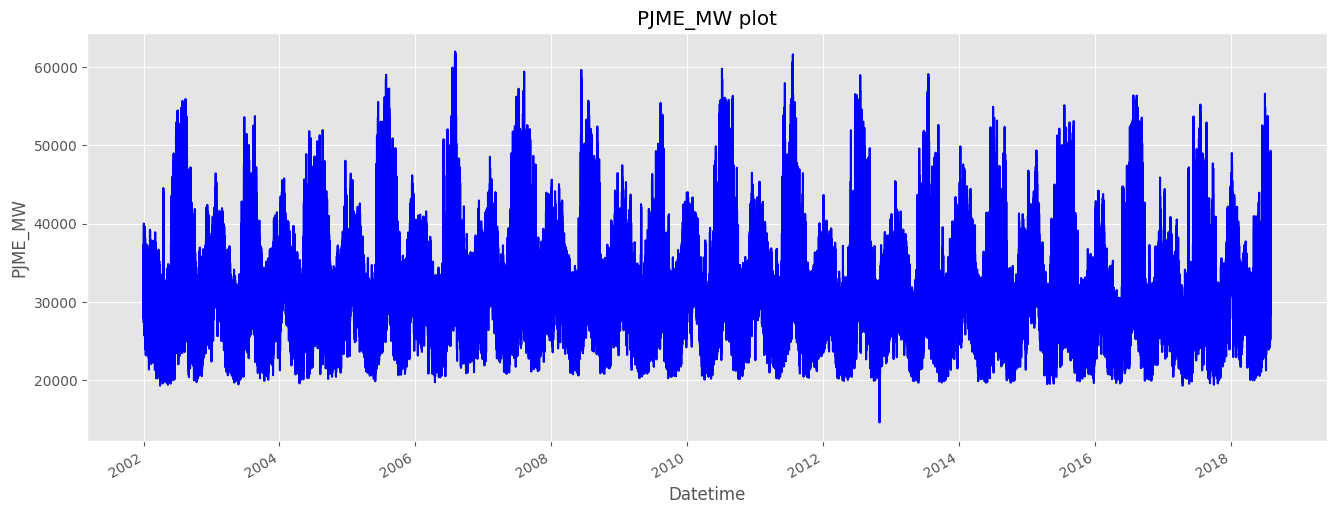

In [10]:
#Plot the time series 
# Use the ggplot style
plt.style.use('ggplot')
ax2 = pjme['PJME_MW'].plot(figsize=(16,6),color='blue')
# Set the title
ax2.set_title('PJME_MW plot');
# Specify the x-axis label 
ax2.set_xlabel('Datetime')
# Specify the y-axis label 
ax2.set_ylabel('PJME_MW')
plt.show()

#### Visualisation of monthly sold products <a id="month"></a>

In [11]:
#extract month information and convert data type
df_train['month'] = df_train['Datetime'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
dff2=df_train.copy()
df_train['month'] = pd.to_datetime(df_train['month'])

In [12]:
#DataFrame dff_train with index of month values, column 'Quantity_month' contains total quantity of goods sold in each month
dff_train = df_train.groupby(['month']).agg({'PJME_MW':'sum'})
dff_train['month'] = dff_train.index
dff_train.drop(['month'],axis=1,inplace=True)
dff_train.rename(columns = {'PJME_MW':'PJME_MW_month'}, inplace = True)

In [13]:
dff_train

,PJME_MW_month
month,
2002-01-01,23089022
2002-02-01,20320720
2002-03-01,21483191
2002-04-01,20516472
2002-05-01,20886798
...,...
2014-09-01,21847173
2014-10-01,20023461
2014-11-01,21486203


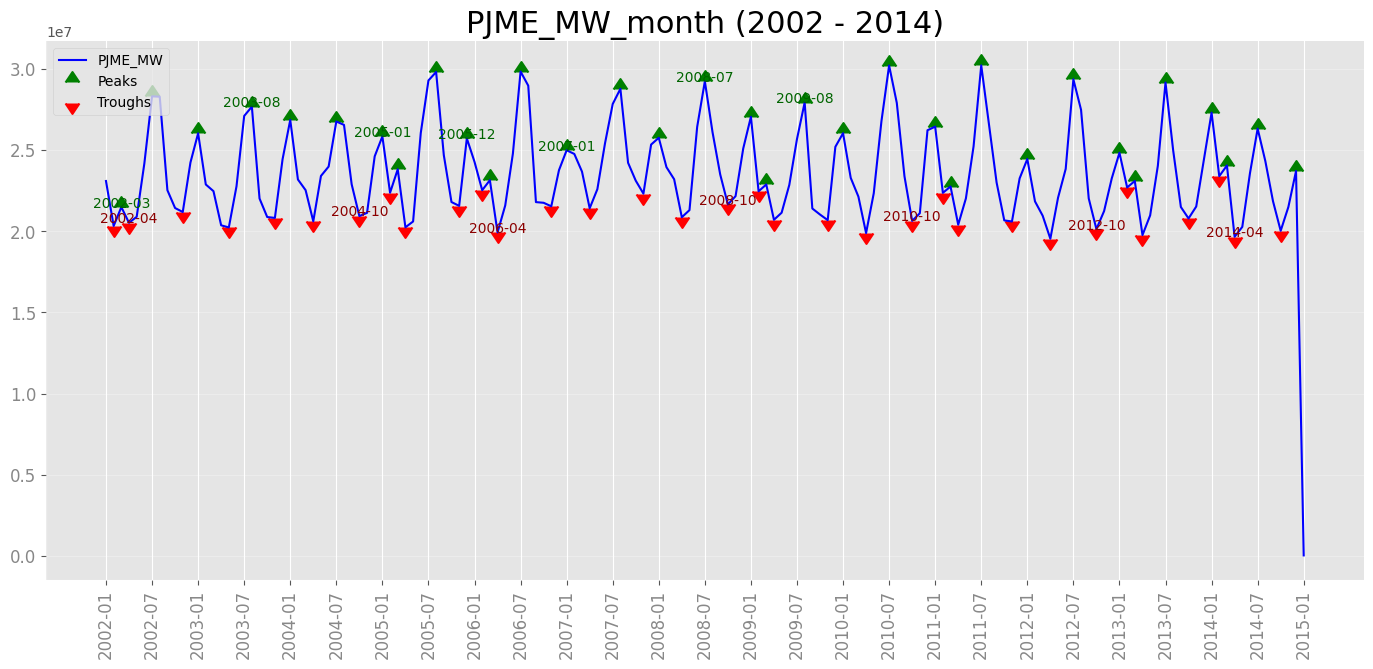

In [14]:
dff2=dff2.groupby(['month']).agg({'PJME_MW':'sum'})

dff2['month'] = dff2.index
dff2.rename(columns = {'PJME_MW':'PJME_MW_month'}, inplace = True)
# Get the Peaks and Troughs
data = dff2['PJME_MW_month'].values
doublediff = np.diff(np.sign(np.diff(data)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*data)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

# Draw Plot
plt.figure(figsize=(17,7))
plt.plot('month', 'PJME_MW_month', data=dff2, color='blue', label='PJME_MW')
plt.scatter(dff2.month[peak_locations], dff2.PJME_MW_month[peak_locations], marker=mpl.markers.CARETUPBASE, color='green', s=100, label='Peaks')
plt.scatter(dff2.month[trough_locations], dff2.PJME_MW_month[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='red', s=100, label='Troughs')

# Annotate
for t, p in zip(trough_locations[1::5], peak_locations[::3]):
    plt.text(dff2.month[p], dff2.PJME_MW_month[p]+15, dff2.month[p], horizontalalignment='center', color='darkgreen')
    plt.text(dff2.month[t], dff2.PJME_MW_month[t]-35, dff2.month[t], horizontalalignment='center', color='darkred')
# Decoration
xtick_location = dff2.index.tolist()[::6]
xtick_labels = dff2.month.tolist()[::6]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, fontsize=12, alpha=.7)
plt.title("PJME_MW_month (2002 - 2014)", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [15]:
trough_locations

array([  1,   3,  10,  16,  22,  27,  33,  37,  39,  46,  49,  51,  58,
        63,  70,  75,  81,  85,  87,  94,  99, 105, 109, 111, 118, 123,
       129, 133, 135, 141, 145, 147, 153], dtype=int64)

#### Seasonality, Trend and Noise <a id="trend"></a>

In [16]:
decomposition=seasonal_decompose(dff_train, model = 'additive')
# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal
sales_decomposed = pd.DataFrame(np.c_[trend, seasonal], index=dff_train.index, columns=['trend', 'seasonal'])

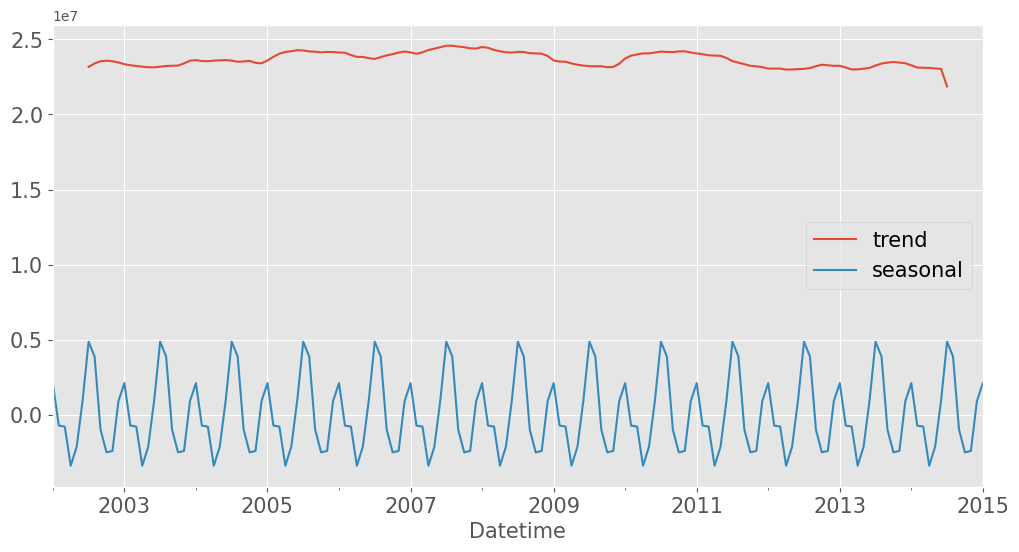

In [17]:
# Plot the values of the sales_decomposed DataFrame
ax = sales_decomposed.plot(figsize=(12, 6), fontsize=15)

# Specify axis labels
ax.set_xlabel('Datetime', fontsize=15)
plt.legend(fontsize=15)
plt.show()

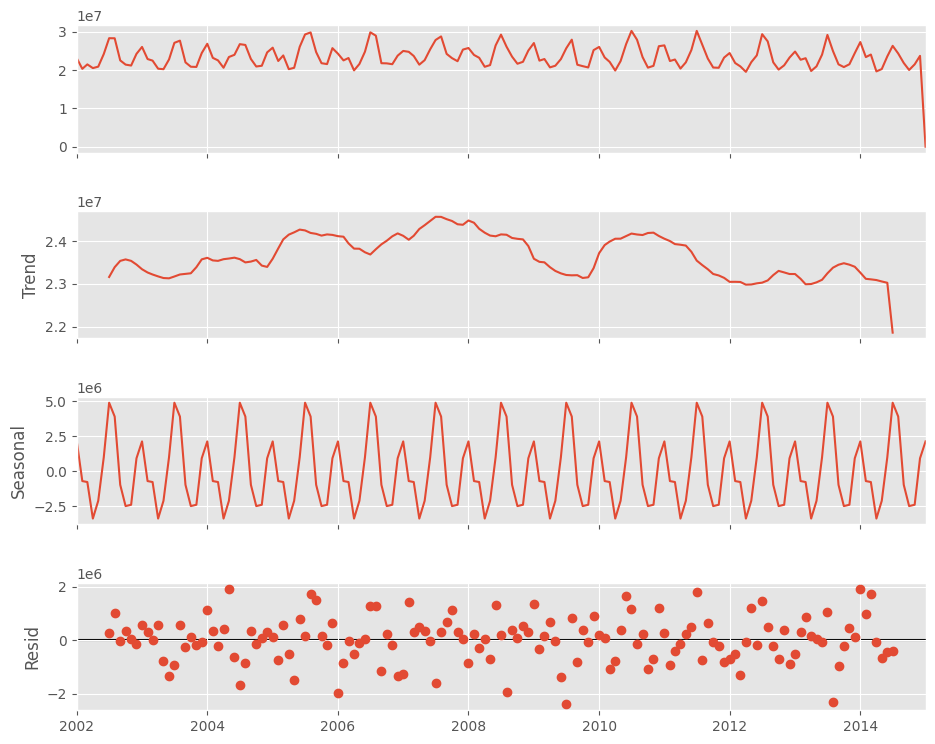

In [18]:
# seasonal_decompose for additive model
seasonal_decompose(dff_train, model = 'additive').plot().set_size_inches(10, 8)

### Future Sales Forecasting with SARIMA model <a id="future"></a>
#### Checks for Stationarity of the time serie <a id="stationarity"></a>

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary. Here, i will use Augmented Dickey Fuller test.The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [19]:
result = adfuller(dff_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.340533
p-value: 0.979130
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.578


#### Autocorrelation in time series data <a id="Autocorrelation"></a>
In order to figure out the parameters p,d,q,P,D,Q of SARIMA model we would need to plot the ACF and PACF plots.
ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.

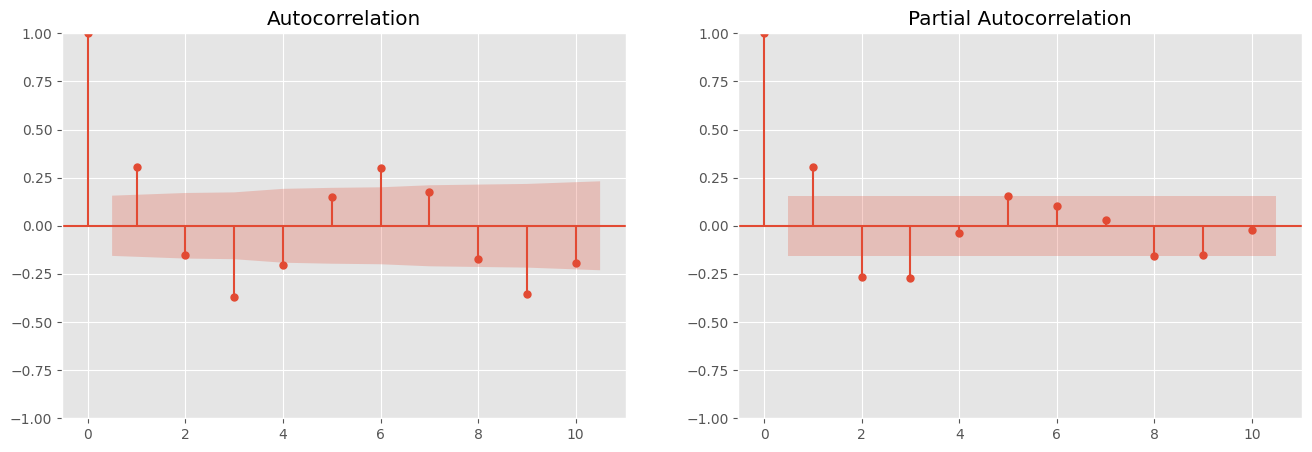

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(dff_train,lags=10, ax=axes[0])
plot_pacf(dff_train,lags=10, ax=axes[1])
plt.show()

#### Parameters estimation & model building <a id="build"></a>

In [21]:
#use auto_arima function from pmdarima library to find the best SARIMA model for dff_train data series.
model=auto_arima(dff_train, start_p = 0, start_q = 0,D=2, m = 12, seasonal = True, test = "adf",  trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,2,1)[12]             : AIC=4318.501, Time=0.16 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=4374.676, Time=0.03 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=4346.389, Time=0.16 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=4320.466, Time=0.14 sec
 ARIMA(0,1,0)(0,2,1)[12]             : AIC=4331.598, Time=0.12 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=4347.574, Time=0.11 sec
 ARIMA(0,1,0)(2,2,1)[12]             : AIC=4315.011, Time=0.36 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=4321.622, Time=0.22 sec
 ARIMA(0,1,0)(2,2,2)[12]             : AIC=4326.989, Time=0.66 sec
 ARIMA(0,1,0)(1,2,2)[12]             : AIC=4330.871, Time=0.28 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=4323.958, Time=0.41 sec
 ARIMA(0,1,1)(2,2,1)[12]             : AIC=4319.257, Time=0.45 sec
 ARIMA(1,1,1)(2,2,1)[12]             : AIC=4320.082, Time=0.52 sec
 ARIMA(0,1,0)(2,2,1)[12] intercept   : AIC=4329.437, Time=0.35 sec

Best model:  ARIMA

According to the algorithm the best SARIMA model is SARIMA(0,1,0)(2,2,1)[12]   

In [22]:
#display summary information about the model SARIMA
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(2, 2, [1], 12)   Log Likelihood               -2153.506
Date:                              Sat, 15 Jul 2023   AIC                           4315.011
Time:                                      15:57:59   BIC                           4326.542
Sample:                                  01-01-2002   HQIC                          4319.697
                                       - 01-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5421      0.296     -1.834      0.067      -1.121       0.037
ar.S.L24      -0.1516      0.140     -1.079      0.281      -0.427       0.124
ma.S.L12      -0.7283      0.205     -3.558      0.000      -1.129      -0.327
sigma2      1.066e+13   1.03e-13   1.04e+26      0.000    1.07e+13    1.07e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):             15061.67
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                            -5.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+41. Standard errors may be unstable.
"""

According to the model summary: Because the p-value of the Ljung-Box test is greater than 0.05, we cannot reject the null hypothesis that the residuals are independent. Because the p-value of the heteroskedasticity test is grater than 0.05, we fail to reject the null hypothesis the null hypothesis of Homoscedasticity. Because the p-value of the Jarque Bera test is grater than 0.05, we fail to reject the null hypothesis and conclude that the sample data follows normal distribution. We conclude that residuals form a white noise, so the the model is good and can be used for prediction.

#### Diagnostics of residuals <a id="diagnostics"></a>

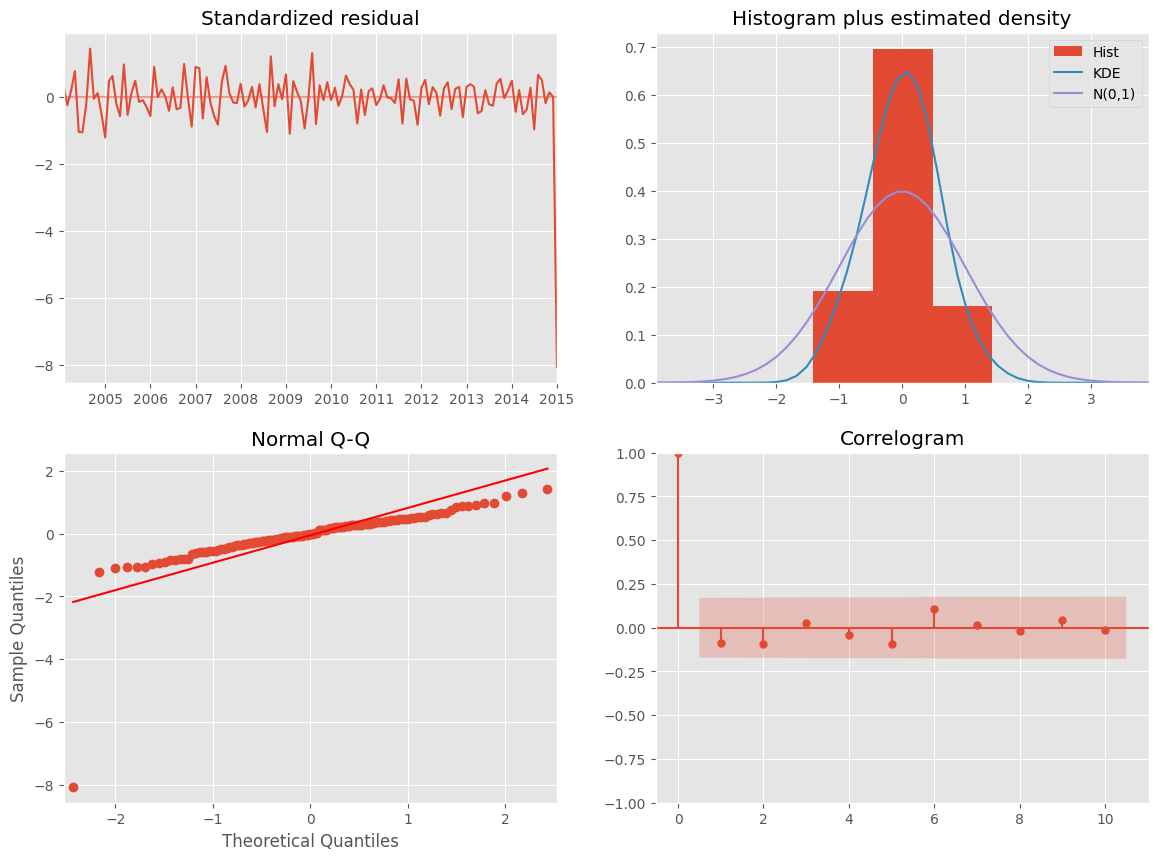

In [23]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

#### Forecasting <a id="forecast"></a>

In [35]:
#value prediction for the next 12 months
prediction, confint = model.predict(n_periods = 44, return_conf_int = True) #95% CI default
start = dff_train.index[-1] + pd.DateOffset(months=1)
period_index = pd.period_range(start=start, periods=44, freq='M')
period_index = period_index.to_timestamp()
prediction

2015-02-01   -3.212216e+06
2015-03-01   -2.595090e+06
2015-04-01   -6.834100e+06
2015-05-01   -5.958533e+06
2015-06-01   -2.898563e+06
2015-07-01    1.003693e+06
2015-08-01   -2.174536e+06
2015-09-01   -4.879638e+06
2015-10-01   -6.227373e+06
2015-11-01   -4.708228e+06
2015-12-01   -2.538167e+06
2016-01-01   -1.863654e+07
2016-02-01   -2.219854e+07
2016-03-01   -2.130402e+07
2016-04-01   -2.617782e+07
2016-05-01   -2.561435e+07
2016-06-01   -2.237428e+07
2016-07-01   -1.893209e+07
2016-08-01   -2.214572e+07
2016-09-01   -2.426553e+07
2016-10-01   -2.565211e+07
2016-11-01   -2.387994e+07
2016-12-01   -2.186290e+07
2017-01-01   -4.466533e+07
2017-02-01   -4.838170e+07
2017-03-01   -4.733627e+07
2017-04-01   -5.260304e+07
2017-05-01   -5.216961e+07
2017-06-01   -4.890422e+07
2017-07-01   -4.558254e+07
2017-08-01   -4.894169e+07
2017-09-01   -5.073254e+07
2017-10-01   -5.212036e+07
2017-11-01   -5.009995e+07
2017-12-01   -4.827427e+07
2018-01-01   -7.521442e+07
2018-02-01   -7.902448e+07
2

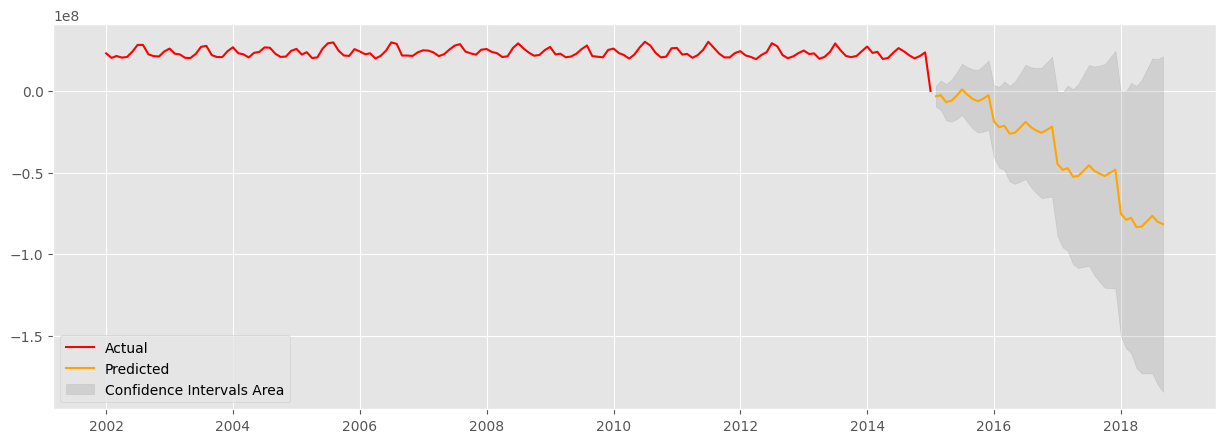

In [36]:
#draw a comparison chart between actual data and predicted value
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')
plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

#### Model evaluation <a id="evaluation"></a>

#### Visualisation of monthly sold products <a id="test-month"></a>

In [26]:
pjme_test['Datetime'] = pjme_test['Datetime'].apply(lambda x: x.to_pydatetime())


#save a copy of sales_train
df_test=pjme_test.copy()

In [27]:
#extract month information and convert data type
df_test['month'] = df_test['Datetime'].dt.to_period('M')
df_test['month'] = df_test['month'].astype(str)
dff2=df_test.copy()
df_test['month'] = pd.to_datetime(df_test['month'])

In [28]:
df_test = df_test.groupby(['month']).agg({'PJME_MW':'sum'})
df_test['month'] = df_test.index
df_test.drop(['month'],axis=1,inplace=True)
df_test.rename(columns = {'PJME_MW':'PJME_MW_month'}, inplace = True)

In [42]:
df_test

,PJME_MW_month
month,
2015-01-01,26266018
2015-02-01,25257011
2015-03-01,23704022
2015-04-01,19222577
2015-05-01,21743326
2015-06-01,23918837
2015-07-01,27109704
2015-08-01,26358884
2015-09-01,23212504


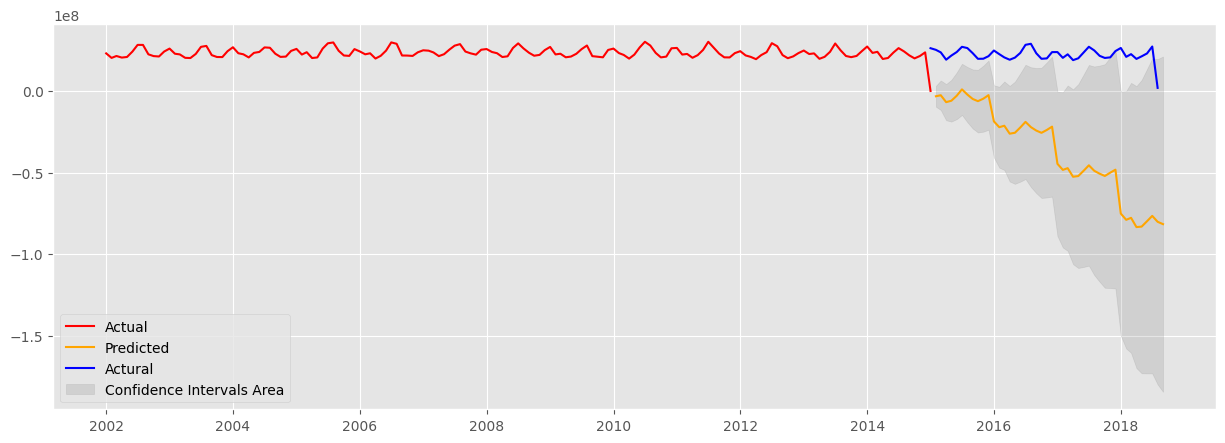

In [37]:
#draw a comparison chart between actual data and predicted value
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')
plt.plot(df_test, color='blue', label='Actural')
plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Giá trị thực tế
actual_values = df_test # Dữ liệu thực tế của 12 quan sát tiếp theo

# Giá trị dự đoán từ mô hình SARIMA
predicted_values = prediction

# Tính giá trị RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print("RMSE:", rmse)



RMSE: 65001963.19083153
